In [317]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

In [221]:
train = pd.read_csv("train_titanic.csv")

In [222]:
df = pd.read_csv("train_titanic.csv")

In [223]:
train.shape

(891, 12)

In [224]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [225]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


<b> Missing data

In [6]:
train.isnull().sum()/train.shape[0]*100

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

In [230]:
train['hasCabin'] = train.Cabin.map(lambda x: 1 if str(x)!='nan' else 0)

In [235]:
train['CabinCat'] = train.Cabin.map(lambda x: x[0] if str(x)!='nan' else 0)

In [245]:
tmp = train.groupby(['CabinCat'])['Fare'].mean().sort_values().reset_index().reset_index().drop('Fare',axis=1)

In [248]:
train = train.merge(tmp,on='CabinCat',how='right')

In [251]:
train = train.rename(columns={"index": "CabienCatNum"})

<b> Drop Cabin, fill Age with median, and fill Embarked with the most common data

In [253]:
train = train.drop("Cabin",axis=1)
train = train.fillna(train.mean())

In [254]:
train.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [255]:
train.Embarked[train.Embarked.isnull()]

832    NaN
874    NaN
Name: Embarked, dtype: object

In [256]:
train = train.fillna(train.mode().iloc[0])

In [257]:
train.Embarked[train.Embarked.isnull()]

Series([], Name: Embarked, dtype: object)

<b> Categorical columns

In [258]:
train.dtypes

PassengerId       int64
Survived          int64
Pclass            int64
Name             object
Sex              object
Age             float64
SibSp             int64
Parch             int64
Ticket           object
Fare            float64
Embarked         object
hasCabin          int64
CabinCat         object
CabienCatNum      int64
dtype: object

In [259]:
train.Sex = pd.get_dummies(train.Sex)['female']

In [261]:
train = pd.concat([train, pd.get_dummies(train.Embarked)],axis=1).drop('Embarked',axis=1)

In [262]:
train['LastName'] = train.Name.map(lambda x: x.split(',')[0])

In [263]:
le = preprocessing.LabelEncoder()
lefit = le.fit(train['LastName'])
train['LastNameEncoding'] = lefit.transform(train['LastName'])
train = train.drop(['Name','LastName'],axis=1)

In [264]:
train.dtypes

PassengerId           int64
Survived              int64
Pclass                int64
Sex                   uint8
Age                 float64
SibSp                 int64
Parch                 int64
Ticket               object
Fare                float64
hasCabin              int64
CabinCat             object
CabienCatNum          int64
C                     uint8
Q                     uint8
S                     uint8
LastNameEncoding      int64
dtype: object

In [265]:
train = train.drop('Ticket',axis=1)

<b> Imbalanced class

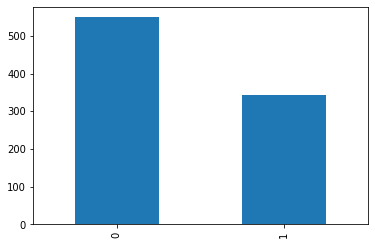

In [266]:
train.Survived.value_counts().plot(kind="bar")

In [267]:
notsurvived = train.Survived.value_counts()[0]/train.Survived.value_counts().sum() * 100
survived = train.Survived.value_counts()[1]/train.Survived.value_counts().sum() * 100

In [268]:
print("{} % did not survived (class 0), i.e {} indiv".format(round(notsurvived,2),train.Survived.value_counts()[0]))
print("{} % did survived (class 0), i.e {} indiv".format(round(survived,2),train.Survived.value_counts()[1]))

61.62 % did not survived (class 0), i.e 549 indiv
38.38 % did survived (class 0), i.e 342 indiv


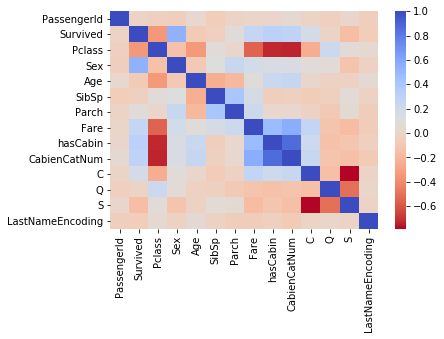

In [269]:
rs = np.random.RandomState(0)
corr = train.corr()
sns.heatmap(corr, cmap='coolwarm_r')
plt.show()

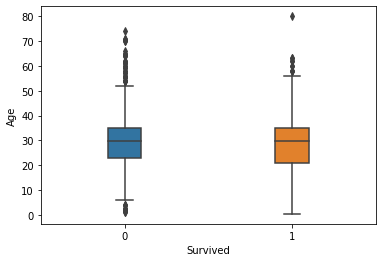

In [272]:
sns.boxplot(x=train.Survived, y=train.Age,orient = "v",width = 0.2)
#sns.boxplot(train.Sex,orient = "v",width = 0.2) 

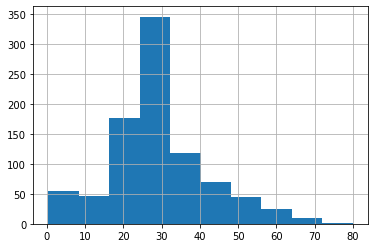

In [315]:
train.Age.hist()

<b> Undersampling

In [273]:
undersampling = train[train.Survived==0][:342]

In [274]:
X = pd.concat([undersampling, train[train.Survived==1]]).reset_index(drop=True)

In [280]:
X = X.drop('CabinCat',axis=1)

<b> Split train/test

In [281]:
X_train, X_test, y_train, y_test = train_test_split(X.iloc[:,X.columns!='Survived'], 
                                                    X.Survived, test_size=0.2, random_state=42)

In [282]:
models = {
    'RandomForest' : RandomForestClassifier(),
    'AdaBoost' : AdaBoostClassifier(),
    'Knn' : KNeighborsClassifier()
}

In [283]:
scores = []
for model in models:
    scores.append(cross_validate_score(models[model], X_train, y_train, cv=5,
                   scoring=('accuracy'))['test_score'].mean())

In [284]:
for i,model in enumerate(models):
    print(f"Accuracy test_score for {model} : {round(scores[i],3)}")

Accuracy test_score for RandomForest : 0.87
Accuracy test_score for AdaBoost : 0.834
Accuracy test_score for Knn : 0.653


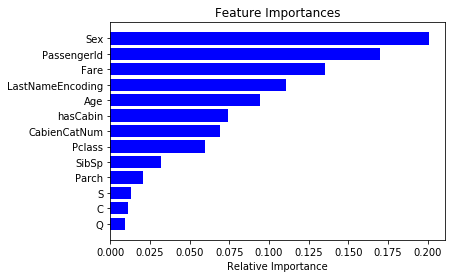

In [285]:
rdf = RandomForestClassifier().fit(X_train,y_train)
features = X_train.columns
importances = rdf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

<b> With dummies Last Name

In [286]:
train['LastName'] = df.Name.map(lambda x: x.split(',')[0])

In [287]:
train_x = pd.concat([train,pd.get_dummies(train.LastName)],axis=1).drop(['LastName'],axis=1)

In [288]:
undersampling_X = train_x[train_x.Survived==0][:342]

In [289]:
X_x = pd.concat([undersampling_X, train_x[train_x.Survived==1]]).reset_index(drop=True)

In [290]:
X_x = X_x.drop(["LastNameEncoding",'CabinCat'],axis=1)

In [126]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=3).fit_transform(X_x.iloc[:,X_x.columns!='Survived'])

In [291]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X_x.iloc[:,X_x.columns != 'Survived'], 
                                                        X_x.Survived, test_size=0.2, random_state=42)

In [292]:
scores1 = []
for model in models:
    scores1.append(cross_validate(models[model], X1_train, y1_train, cv=5,
                   scoring=('accuracy'))['test_score'].mean())

In [293]:
for i,model in enumerate(models):
    print(f"Accuracy test_score for {model} : {round(scores1[i],3)}")

Accuracy test_score for RandomForest : 0.861
Accuracy test_score for AdaBoost : 0.826
Accuracy test_score for Knn : 0.654


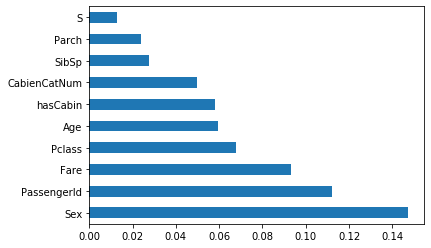

In [294]:
rdf = RandomForestClassifier().fit(X1_train,y1_train)
feat_importances = pd.Series(rdf.feature_importances_, index=X1_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

<b> GridSearch parameters

In [319]:
params_rf = {'n_estimators':[10,20,30,40,50,60,70,80,90],
            'criterion': ['gini', 'entropy'],
             'max_depth':[2,3,4,5],
             'min_weight_fraction_leaf':[0.,1.],
             'max_features': ['auto', 'sqrt', 'log2']
            }
rf_grid = GridSearchCV(RandomForestClassifier(), params_rf)
rf_fit = rf_grid.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit faile

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit faile

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit faile

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit faile

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit faile

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit faile

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit faile

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit faile

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit faile

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit faile

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit faile

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit faile

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit faile

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit faile

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit faile

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit faile

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit faile

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit faile

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit faile

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit faile

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit faile

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit faile

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit faile

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit faile

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit faile

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit faile

In [320]:
rf_fit.best_params_ 

{'criterion': 'entropy',
 'max_depth': 5,
 'max_features': 'log2',
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 40}

In [321]:
rf_fit.best_score_

0.8719266055045871

In [322]:
y_pred_rf = rf_fit.predict(X_test)
rf_cf = confusion_matrix(y_test, y_pred_rf)

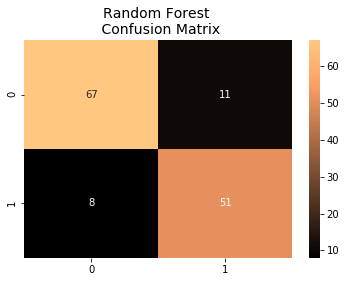

In [331]:
fig = plt.plot(figsize=(22,12))
sns.heatmap(rf_cf, annot=True, cmap=plt.cm.copper)
plt.title("Random Forest \n Confusion Matrix", fontsize=14)

plt.show()

In [193]:
params_knn = {'n_neighbors':[3,5,7,9,11,15,17,19,21,23,25,30,35,40,45],
            'weights': ['uniform', 'distance'],
             'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']
            }
knn_grid = GridSearchCV(KNeighborsClassifier(), params_knn)
knn_fit = knn_grid.fit(X_train, y_train)

In [194]:
knn_fit.best_params_

{'algorithm': 'auto', 'n_neighbors': 21, 'weights': 'distance'}

In [195]:
knn_fit.best_score_

0.6909758131776481

In [295]:
knn_fit_ = KNeighborsClassifier().fit(X_train, y_train)

In [304]:
knn_fit_.score(X_train, y_train)

0.793418647166362

In [306]:
k_feat = [3,5,7,9,11,15,17,19,21,23,25,30,35,40,45]
knn_scores = [] 
for k in k_feat:
    knn_fit_ = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
    knn_scores.append(knn_fit_.score(X_train, y_train))

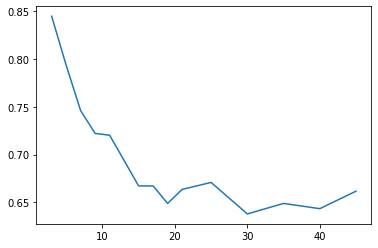

In [309]:
plt.plot(k_feat,knn_scores)

In [310]:
np.argmax(knn_scores)

0

In [314]:
knn_fit_ = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train)
knn_fit_.score(X_train, y_train)

0.8446069469835467

# Steps

In [334]:
from sklearn.model_selection import cross_val_score

In [345]:
models = {
    'RandomForest' : RandomForestClassifier(),
    'AdaBoost' : AdaBoostClassifier(),
    'Knn' : KNeighborsClassifier()
}

In [346]:
scores_cv = []
for model in models:
    scores_cv.append(cross_val_score(models[model], X_train, y_train, cv=5,).mean())

In [347]:
for i,model in enumerate(models):
    print(f"Accuracy test_score for {model} : {round(scores_cv[i],3)}")

Accuracy test_score for RandomForest : 0.865
Accuracy test_score for AdaBoost : 0.834
Accuracy test_score for Knn : 0.653


In [391]:
params_rf = {'n_estimators':[10,20,30,40,50,60,70,80,90,100],
            'criterion': ['gini', 'entropy'],
             'max_depth':[2,3,4,5,None],
             'min_weight_fraction_leaf':[0.,0.3,0.5],
             'max_features': ['auto', 'sqrt', 'log2']
            }
rf_grid = GridSearchCV(RandomForestClassifier(), params_rf)
rf_fit = rf_grid.fit(X_train, y_train)

In [392]:
rf_cv = cross_val_score(rf_fit.best_estimator_,X_train,y_train)

In [393]:
rf_cv.mean()

0.8645704753961635

In [394]:
rf_best = rf_fit.best_estimator_.fit(X_train,y_train)

In [395]:
y_pred_rf = rf_best.predict(X_test)
rf_cf = confusion_matrix(y_test, y_pred_rf)

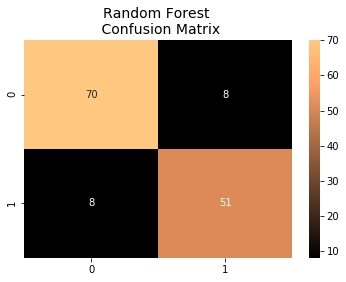

In [396]:
fig = plt.plot(figsize=(22,12))
sns.heatmap(rf_cf, annot=True, cmap=plt.cm.copper)
plt.title("Random Forest \n Confusion Matrix", fontsize=14)

plt.show()

In [397]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_curve, auc

In [398]:
print(f"Accuracy score: {round(accuracy_score(y_test, y_pred_rf),3)}")
print(f"Recall score: {round(recall_score(y_test, y_pred_rf),3)}")
print(f"Precision score: {round(precision_score(y_test, y_pred_rf),3)}")

Accuracy score: 0.883
Recall score: 0.864
Precision score: 0.864


In [399]:
rf_pred_proba = rf_best.predict_proba (X_test)

In [400]:
fpr_rf, tpr_rf, _ = roc_curve(y_test,rf_pred_proba[:,1])

In [401]:
auc_rf = round(auc(fpr_rf, tpr_rf),3)

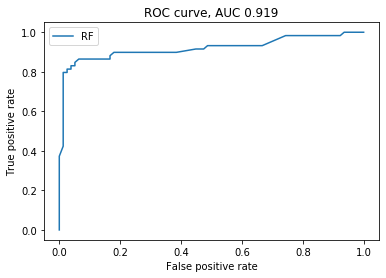

In [402]:
plt.plot(fpr_rf, tpr_rf,label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title(f'ROC curve, AUC {auc_rf}')
plt.legend(loc='best')
plt.show()